In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


In [2]:
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

Here we have title creation tool so that according to our topic it create a title

In [3]:
def title_creator(topic:str) -> str:
    
    """
    Generates a catchy and relevant title for a blog post based on the given topic.
    
    Args:
        topic (str): The topic of the blog post.
    
    Returns:
        str: The generated title.
    """

    llm=ChatOpenAI(model="gpt-4o")
    
    messages1 = [
    (
        "system",
        "You are a helpful assistant that creates a catchy and relevant titles for a blog post, dont ask return question just answer it",
    ),
    ("human", topic),
]
    
    title=llm.invoke(messages1)
    
    return title.content


Here we have created another tool generate_content, it generates content for the title we got from the above tool

In [4]:
def generate_content(title:str)->str:
    
    """
    Generates a detailed and engaging blog post based on the given title and topic.
    
    Args:
        title (str): The title of the blog post.
    
    Returns:
        str: The generated blog content
    """
    
    llm=ChatOpenAI(model="gpt-4o")
    
    messages2 = [
    (
        "system",
        "You are a helpful assistant that writes a detailed and engaging blog post based on the topic and title, dont ask return question just answer it",
    ),
    ("human", title),
]
    
    
    content=llm.invoke(messages2)
    
    return content.content

First we will see each subsequential nodes as super steps,
when binding tools with the llm in the below code i have used parallel_tool_calls as False to avoid parallel execution of the two tools at a time

In [5]:
llm=ChatOpenAI(model="gpt-4o")

tools=[title_creator,generate_content]

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)

In [6]:
sys_msg=SystemMessage(content="you are an helpful assistant tasked with writing the blog from the input")

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}



Checkpoints:
We are adding a checkpointer to the workflow to save the state at different nodes. This allows us to resume from the last saved node in case of any interruption during execution.

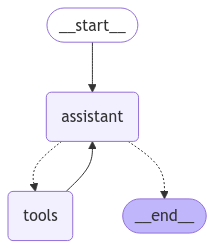

In [7]:
builder=StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

builder.add_edge("tools","assistant")

memory=MemorySaver()

react_graph=builder.compile(checkpointer=memory)

display(Image(react_graph.get_graph().draw_mermaid_png()))

Threads: Running Workflows in Parallel
Each thread represents an independent execution instance, allowing multiple users or tasks to run separately.

Here, we can run different instances of the AI workflow by using different thread_ids, ensuring that each instance runs independently without interfering with the others.

In [11]:
config1={"configurable":{"thread_id":"1"}}

messages=[HumanMessage(content="How AI is Transforming Education for Educators")]

messages = react_graph.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()
    
    

================================ Human Message =================================

How AI is Transforming Education for Educators
================================== Ai Message ==================================
Tool Calls:
  title_creator (call_inRfZ9zz1yeY8MFjUKAgE1K9)
 Call ID: call_inRfZ9zz1yeY8MFjUKAgE1K9
  Args:
    topic: How AI is Transforming Education for Educators
================================= Tool Message =================================
Name: title_creator

"Revolutionizing the Classroom: How AI Empowers Educators and Students Alike"
================================== Ai Message ==================================
Tool Calls:
  generate_content (call_ImnpMUlBXyQQmWBqaHEU12jj)
 Call ID: call_ImnpMUlBXyQQmWBqaHEU12jj
  Args:
    title: Revolutionizing the Classroom: How AI Empowers Educators and Students Alike
================================= Tool Message =================================
Name: generate_content

**Revolutionizing the Classroom: How AI Empowers Educators a

In [13]:
config2={"configurable":{"thread_id":"2"}}

messages=[HumanMessage(content="Artificial intelligence is not just about automation; it's about augmentation—enhancing human creativity, decision-making, and problem-solving in ways we never imagined.")]

messages = react_graph.invoke({"messages": messages},config2)
for m in messages['messages']:
    m.pretty_print()
    

================================ Human Message =================================

Artificial intelligence is not just about automation; it's about augmentation—enhancing human creativity, decision-making, and problem-solving in ways we never imagined.
================================== Ai Message ==================================
Tool Calls:
  title_creator (call_L1dBycov9xC0PY2DJMPJSu2A)
 Call ID: call_L1dBycov9xC0PY2DJMPJSu2A
  Args:
    topic: Artificial Intelligence: Augmenting Human Creativity and Decision-Making
================================= Tool Message =================================
Name: title_creator

"Beyond Imagination: How AI Elevates Human Creativity and Decision-Making"
================================== Ai Message ==================================
Tool Calls:
  generate_content (call_WCJ1iYzAvA3YQDT6LKvJyv4Z)
 Call ID: call_WCJ1iYzAvA3YQDT6LKvJyv4Z
  Args:
    title: Beyond Imagination: How AI Elevates Human Creativity and Decision-Making
======================

In [12]:
messages=[HumanMessage(content="Given the transformative role of AI in education, how can educators balance the use of AI-driven tools with traditional teaching methods to maintain a human-centered learning experience?")]

messages = react_graph.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()



================================ Human Message =================================

How AI is Transforming Education for Educators
================================== Ai Message ==================================
Tool Calls:
  title_creator (call_inRfZ9zz1yeY8MFjUKAgE1K9)
 Call ID: call_inRfZ9zz1yeY8MFjUKAgE1K9
  Args:
    topic: How AI is Transforming Education for Educators
================================= Tool Message =================================
Name: title_creator

"Revolutionizing the Classroom: How AI Empowers Educators and Students Alike"
================================== Ai Message ==================================
Tool Calls:
  generate_content (call_ImnpMUlBXyQQmWBqaHEU12jj)
 Call ID: call_ImnpMUlBXyQQmWBqaHEU12jj
  Args:
    title: Revolutionizing the Classroom: How AI Empowers Educators and Students Alike
================================= Tool Message =================================
Name: generate_content

**Revolutionizing the Classroom: How AI Empowers Educators a